# The Future is Now: Patterns in Global Temperature Trends Across the World

Continued from `Analysis 1.ipynb`.

## Dependency Installation & Imports

In [9]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels networkx pyvis dtaidistance

  Using cached dtaidistance-2.3.11-cp310-cp310-win_amd64.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastdtw import fastdtw
from pyvis.network import Network
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import linregress, zscore
from dtaidistance import dtw

In [3]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', None)

In [4]:
global_correlation = 0.895059831369191

In [5]:
with open('Data_augmented.csv', 'r', encoding='utf-8') as file:
    df = pd.read_csv(file, encoding='utf-8')

df = df.drop(['Latitude', 'Longitude', 'AbsLatitude', 'AbsLongitude'], axis=1)

df.head()

,City,Year,AverageTemperature,Country,NumericLatitude,NumericLongitude,Continent,kcc
0,A Coruña,1880,12.837750,Spain,43.37097,-8.395943,Europe,Csb
1,A Coruña,1881,13.405000,Spain,43.37097,-8.395943,Europe,Csb
2,A Coruña,1882,12.776250,Spain,43.37097,-8.395943,Europe,Csb
3,A Coruña,1883,12.260833,Spain,43.37097,-8.395943,Europe,Csb
4,A Coruña,1884,12.693250,Spain,43.37097,-8.395943,Europe,Csb


In [6]:
df.describe()

,Year,AverageTemperature,NumericLatitude,NumericLongitude
count,461612.000000,461612.000000,461612.000000,461612.000000
mean,1946.555872,17.751024,22.771432,33.197200
std,38.654517,7.689601,23.323688,74.221289
min,1880.000000,-14.812000,-53.162569,-149.894852
25%,1913.000000,11.487646,9.340016,-5.930183
50%,1947.000000,18.502333,27.583333,36.309581
75%,1980.000000,25.236854,39.690552,100.925671
max,2013.000000,31.082625,69.344405,176.167505


## Further Pattern Examination

### Data Preparation (Standardization)

Be warned, the cell below may take ~20 minutes to run.

In [7]:
# Create a temperature profile for each city
city_profiles = df.pivot(index='Year', columns='City', values='AverageTemperature').ffill().bfill()

# Normalize with z-scores
city_profiles_standardized = (city_profiles - city_profiles.mean()) / city_profiles.std()

# Convert to numpy array for faster operations
data_array = city_profiles_standardized.to_numpy().T  # Transpose for city-wise operation

In [8]:
cities = city_profiles_standardized.columns
num_cities = len(cities)

In [9]:
sequences = [city_profiles_standardized[city].values for city in city_profiles_standardized.columns]
matrix_dtw = dtw.distance_matrix_fast(sequences)

In [10]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
matrix_cities = mds.fit_transform(matrix_dtw)

In [11]:
# Euclidean distances between all city pairs
distances_euclid = pdist(city_profiles_standardized.transpose(), metric='euclidean')

# condensed distance matrix -> square
matrix_euclid = squareform(distances_euclid)

In [12]:
vector_length = city_profiles_standardized.shape[0]
print(f"Each city's temperature profile vector length (number of years): {vector_length}")

Each city's temperature profile vector length (number of years): 134


Save the relevant variables from the above cell into files so we don't have to re-run this same cell in future notebooks.

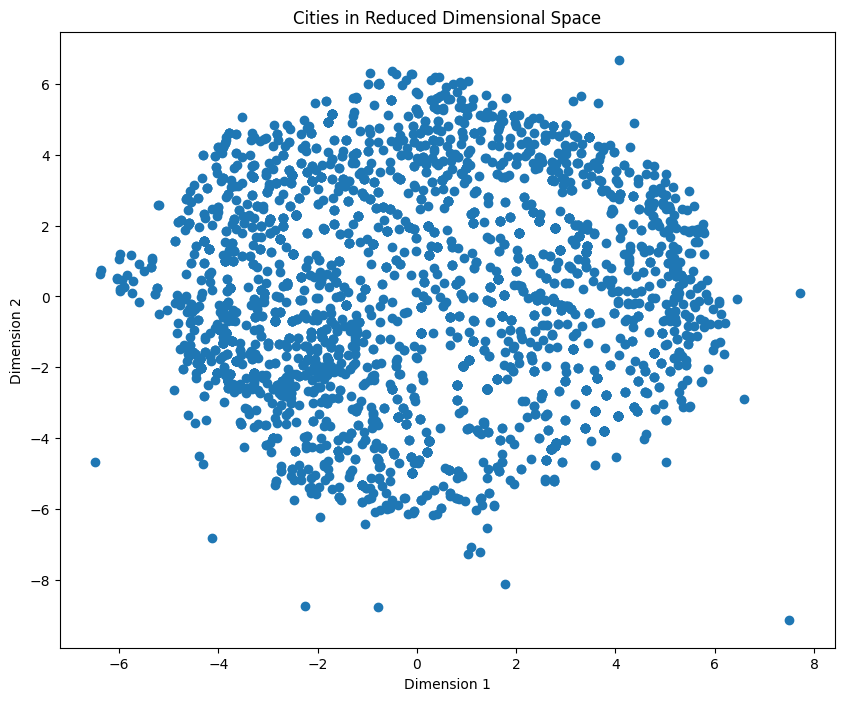

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(matrix_cities[:, 0], matrix_cities[:, 1])
plt.title('Cities in Reduced Dimensional Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [14]:
# Find most strongly correlated city pairs for Euclidean & DTW matrices
def find_strongly_correlated_city_pairs(distance_matrix, cities, percentile=2.5):
    # Remove self distances
    distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    
    # Threshold for top {percentile}
    threshold = np.percentile(distances, percentile)

    strong_pair_indices = np.where((distance_matrix <= threshold) & (distance_matrix > 0))
    strong_pairs = sorted([(min(cities[i], cities[j]), max(cities[i], cities[j]), distance_matrix[i, j])
                           for i, j in zip(*strong_pair_indices)], key=lambda x: (x[0], x[1]))
    
    return strong_pairs, threshold

strong_pairs_euclid, thres_euclid = find_strongly_correlated_city_pairs(matrix_euclid, cities)
strong_pairs_dtw, thres_dtw = find_strongly_correlated_city_pairs(matrix_dtw, cities)

# Make a set out of the strongest pairs from both euclidian and dtw distance matrices
strong_pairs_merged = set(strong_pairs_euclid + strong_pairs_dtw)

#for pair in sorted(strong_pairs_merged, key=lambda x: x[2]):
#    print(f"{pair[0]} and {pair[1]} have a strong correlation with a distance of {pair[2]:.2f}")

In [15]:
print(len(strong_pairs_merged))

274157


**Interpretation of strongly-associated cities**

Most of these groupings are geographically close to each other, so not particularly noteworthy.

### Representative-Based Clustering with k-means

1. Try to find optimal number of clusters for k-means by using silhouette score and elbow method.
2. Perform k-means clustering with apparently optimal number of clusters, visualize them.
   1. Examine the relative abundance of Continents and climate types compared to the whole dataset
   2. Examine the correlation between AverageTemperature and Year relative to the global correlation

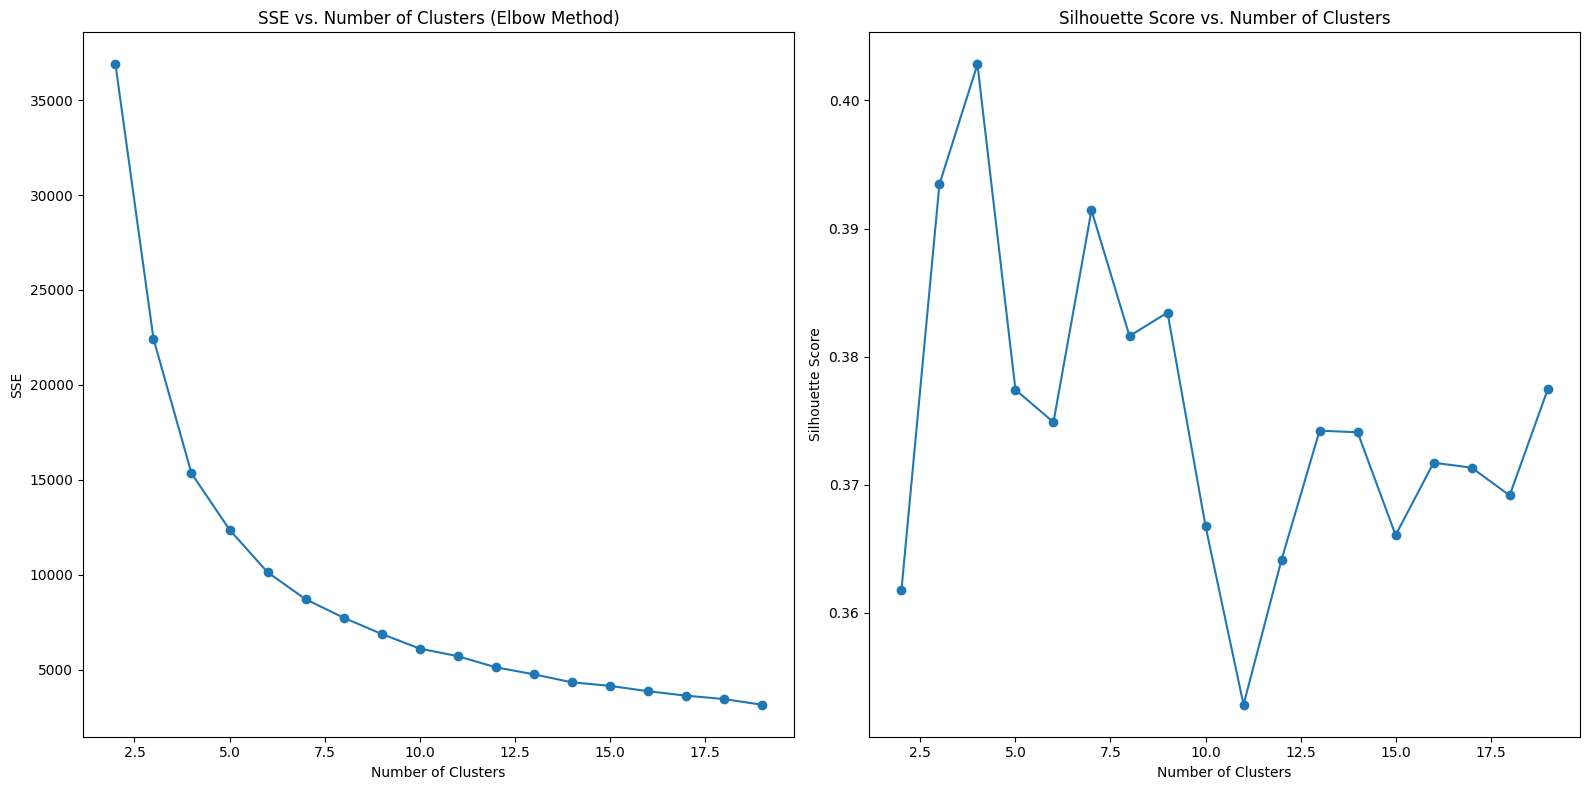

In [16]:
cluster_range = range(2, 20)
silhouette_scores = []
sse_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(matrix_cities)
    
    silhouette_avg = silhouette_score(matrix_cities, labels)
    silhouette_scores.append(silhouette_avg)
    sse_scores.append(kmeans.inertia_)
    
plt.figure(figsize=(16, 8))

# Elbow Method graph
plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_scores, marker='o')
plt.title('SSE vs. Number of Clusters (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

# Silhouette score graph
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

For the elbow method it looks like 3 or 4 clusters is ideal, and going by silhouette score it peaks at 4 clusters, so we'll do k-means clustering with k=4.

In [20]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(matrix_cities)

silhouette_avg = silhouette_score(matrix_cities, labels)
print(f'Silhouette Score for {n_clusters} clusters: {silhouette_avg:.2f}')

Silhouette Score for 4 clusters: 0.40


In [21]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Assuming 'labels' are the cluster labels from KMeans
# and 'matrix_cities' is your feature matrix used for clustering

silhouette_avg = silhouette_score(matrix_cities, labels)
calinski_harabasz = calinski_harabasz_score(matrix_cities, labels)
davies_bouldin = davies_bouldin_score(matrix_cities, labels)

print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.2f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")

Silhouette Score for 4 clusters: 0.40
Calinski-Harabasz Index: 3248.08
Davies-Bouldin Index: 0.78


In [1]:
plt.figure(figsize=(10, 8))
plt.scatter(matrix_cities[:, 0], matrix_cities[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-means Clustering with 4 Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

NameError: name 'plt' is not defined

In [26]:
city_names = df['City'].drop_duplicates(keep='first').tolist()
city_clusters = {city: label for city, label in zip(city_names, labels)}

# Mapping w/ city info
city_info = df.drop_duplicates(subset='City', keep='first').set_index('City')[['Country', 'NumericLatitude', 'NumericLongitude', 'Continent', 'kcc']]

clustered_data = []

for city, cluster_label in city_clusters.items():
    info = city_info.loc[city].to_dict()
    info['City'] = city
    info['Cluster'] = cluster_label
    clustered_data.append(info)

df_kmeans = pd.DataFrame(clustered_data)

df_kmeans = df_kmeans.sort_values(by=['Cluster', 'City']).reset_index(drop=True)

outfile = 'Data_kmeans.csv'
df_kmeans.to_csv(f'{outfile}', index=False)

print(f'Exported clustered cities to {outfile}')

Exported clustered cities to Data_kmeans.csv


#### Cluster visualizations

1. Unique Cities in each cluster
2. Unique Countries in each cluster
3. Proportion of Continents in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
4. Proportion of climates in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
5. For each cluster:
   1. Averaged AverageTemperature by Year & correlations
   2. AverageTemperature by Year & correlations
   3. Box & Whiskers plots to look at geographic spread (Latitude, Longitude)

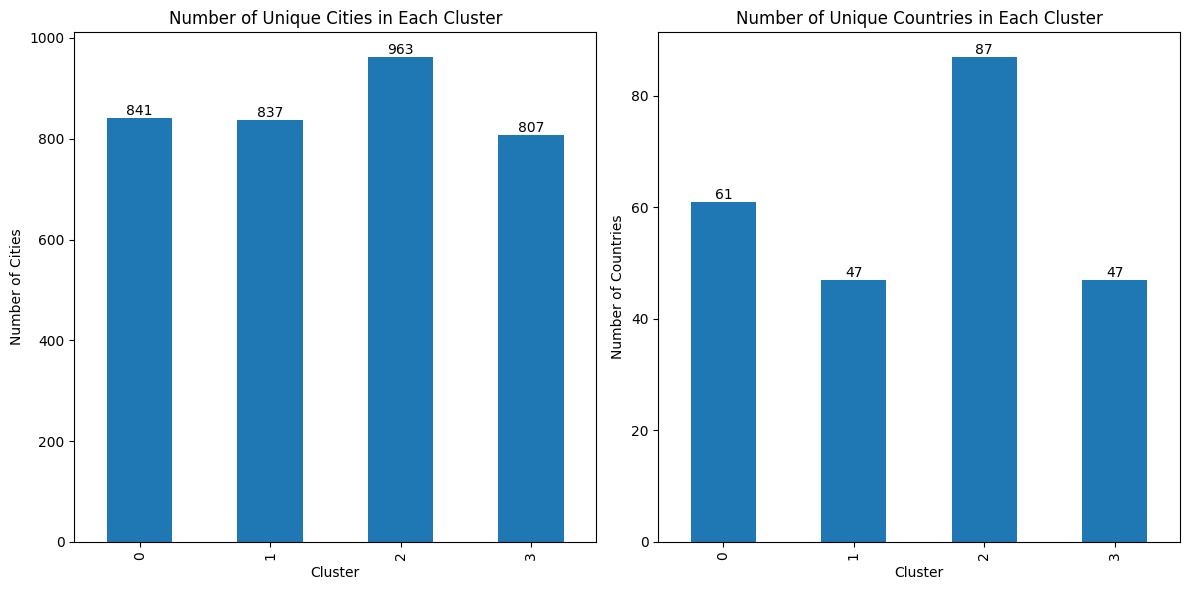

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cities_per_cluster = df_kmeans.groupby('Cluster')['City'].nunique()
cities_per_cluster.plot(kind='bar')
plt.title('Number of Unique Cities in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
for index, value in enumerate(cities_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
countries_per_cluster = df_kmeans.groupby('Cluster')['Country'].nunique()
countries_per_cluster.plot(kind='bar')
plt.title('Number of Unique Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
for index, value in enumerate(countries_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

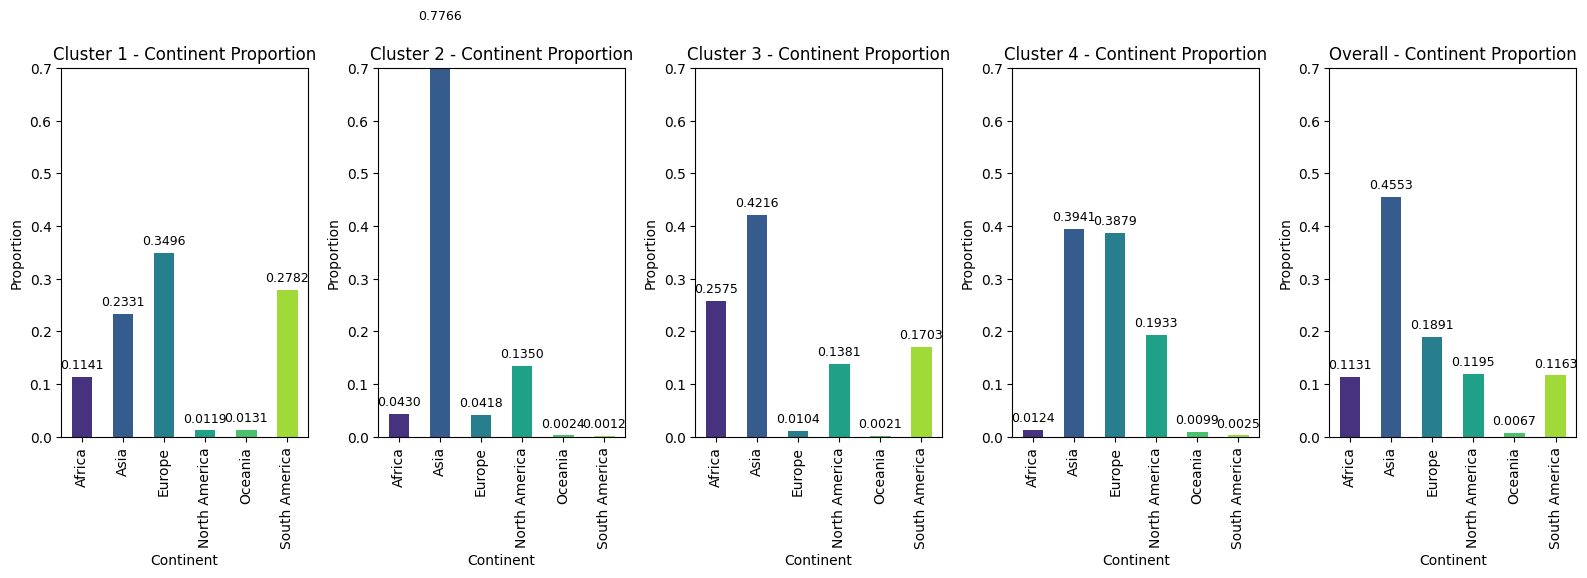

In [28]:
plt.figure(figsize=(16, 6))

for i in range(n_clusters):
    plt.subplot(1, n_clusters + 1, i+1)
    cluster_data = df_kmeans[df_kmeans['Cluster'] == i]
    continent_counts = cluster_data['Continent'].value_counts(normalize=True).sort_index()
    bars = continent_counts.plot(kind='bar', color=sns.color_palette("viridis", len(continent_counts)))
    plt.title(f'Cluster {i+1} - Continent Proportion')
    plt.ylabel('Proportion')
    plt.xlabel('Continent')
    plt.ylim(0.0, 0.70)
    for index, value in enumerate(continent_counts):
        plt.text(index, value + 0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=9, color='black')

# Adding a graph for the overall proportions of each continent in the dataset
plt.subplot(1, n_clusters + 1, n_clusters + 1)
overall_continent_counts = df_kmeans['Continent'].value_counts(normalize=True).sort_index()
bars = overall_continent_counts.plot(kind='bar', color=sns.color_palette("viridis", len(overall_continent_counts)))
plt.title('Overall - Continent Proportion')
plt.ylabel('Proportion')
plt.xlabel('Continent')
plt.ylim(0.0, 0.70)

for index, value in enumerate(overall_continent_counts):
    plt.text(index, value + 0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


Visualizing the clusters as a heatmap:

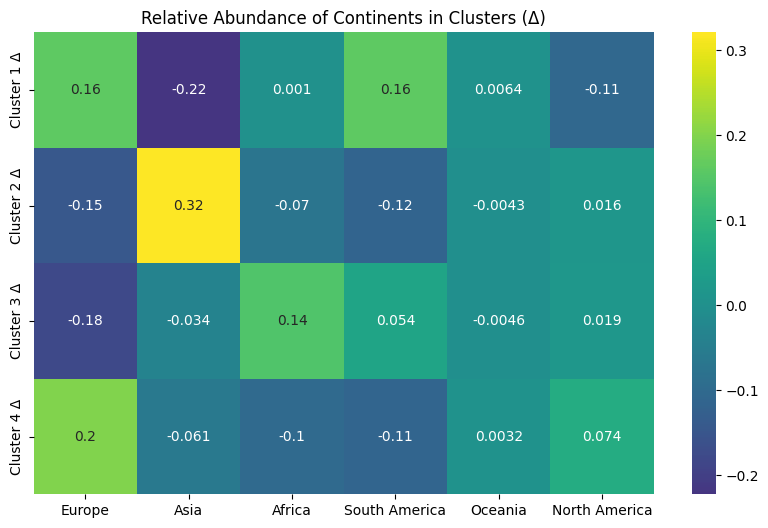

In [29]:
continents = df_kmeans['Continent'].unique()
overall_continent_counts = df_kmeans['Continent'].value_counts(normalize=True)

# Initialize a DataFrame to store the deltas
deltas = pd.DataFrame(index=continents)

# Calculate deltas for each cluster
for i in range(n_clusters):
    cluster_data = df_kmeans[df_kmeans['Cluster'] == i]
    continent_counts = cluster_data['Continent'].value_counts(normalize=True)
    deltas[f'Cluster {i+1} Δ'] = continent_counts - overall_continent_counts

# Transpose the DataFrame for easier plotting with seaborn
deltas = deltas.transpose()

# Replace NaN values with 0 (indicating no difference for missing continents in some clusters)
deltas.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(deltas, annot=True, cmap="viridis", center=0)
plt.title('Relative Abundance of Continents in Clusters (Δ)')
plt.show()

Now let's see if we can find anything interesting if we graph AverageTemperature by Year for each cluster.

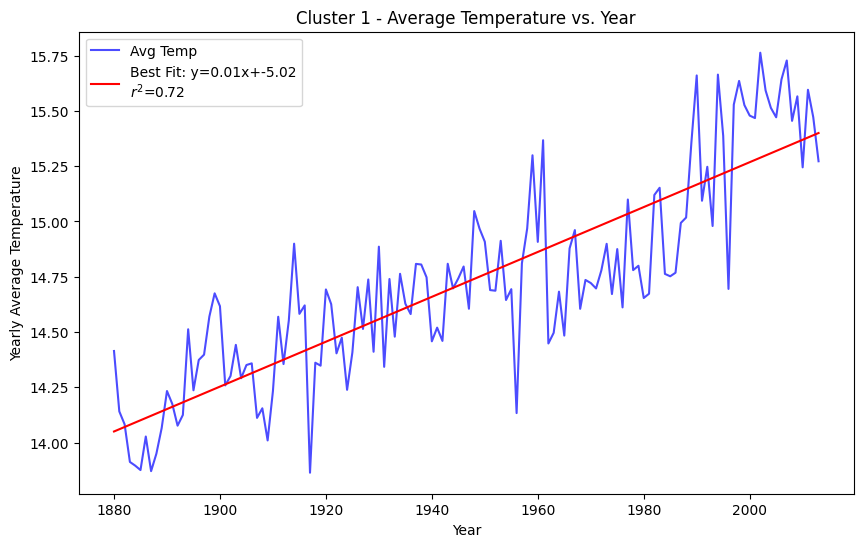

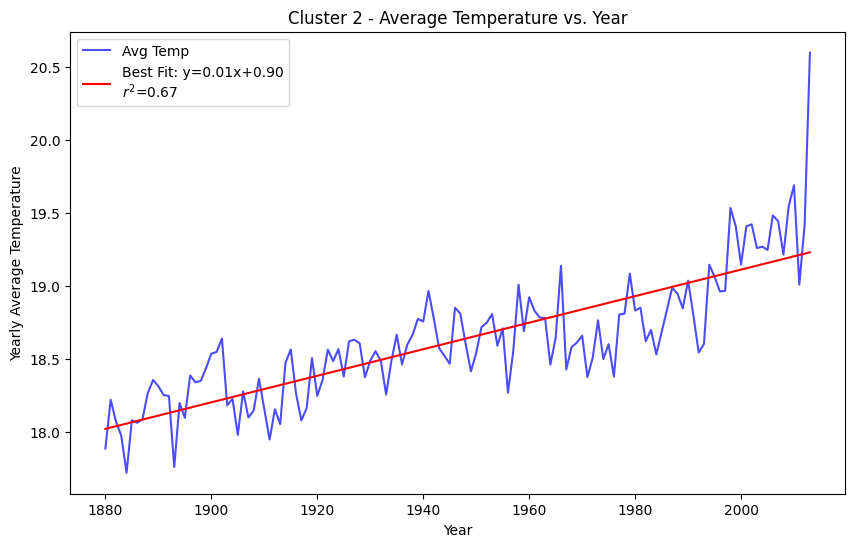

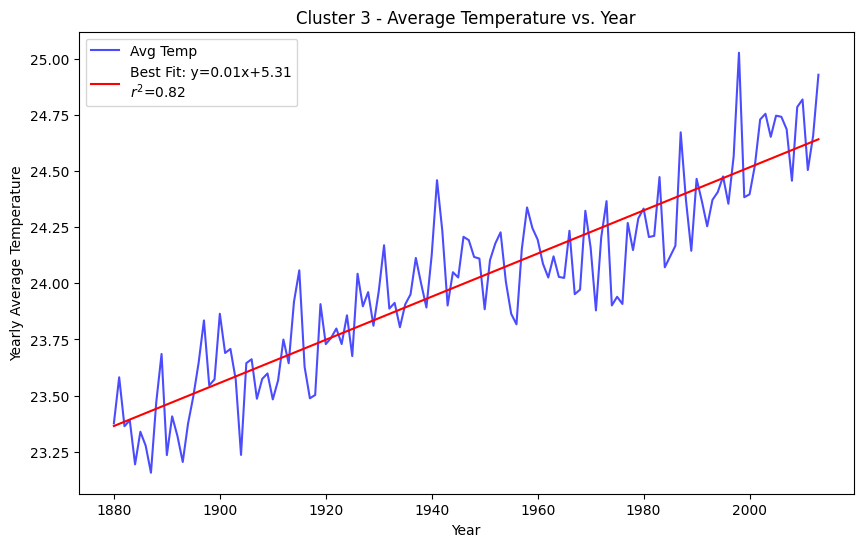

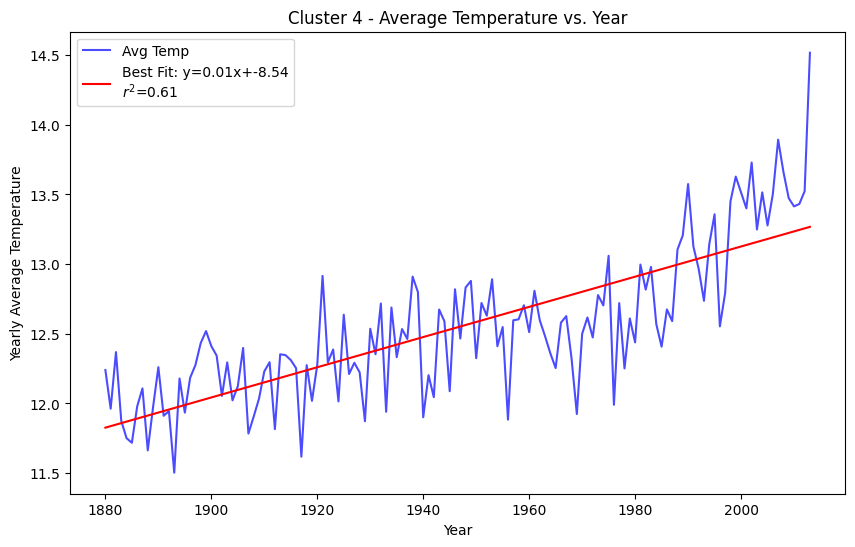

In [30]:
merged_df = pd.merge(df, df_kmeans[['City', 'Cluster']], on='City', how='left')

for cluster in range(merged_df['Cluster'].nunique()):
    plt.figure(figsize=(10, 6))
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    
    # get yearly average temps
    yearly_avg_temp = cluster_data.groupby('Year')['AverageTemperature'].mean()
    
    years = yearly_avg_temp.index.values
    avg_temps = yearly_avg_temp.values
    
    plt.plot(years, avg_temps, label='Avg Temp', color='blue', alpha=0.7)
    
    # line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(years, avg_temps)
    plt.plot(years, intercept + slope*years, label=f'Best Fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}', color="red")
    
    plt.title(f'Cluster {cluster+1} - Average Temperature vs. Year')
    plt.xlabel('Year')
    plt.ylabel('Yearly Average Temperature')
    plt.legend()
    plt.show()

Now to do the same thing with climate classifications to determine if there are any interesting results:

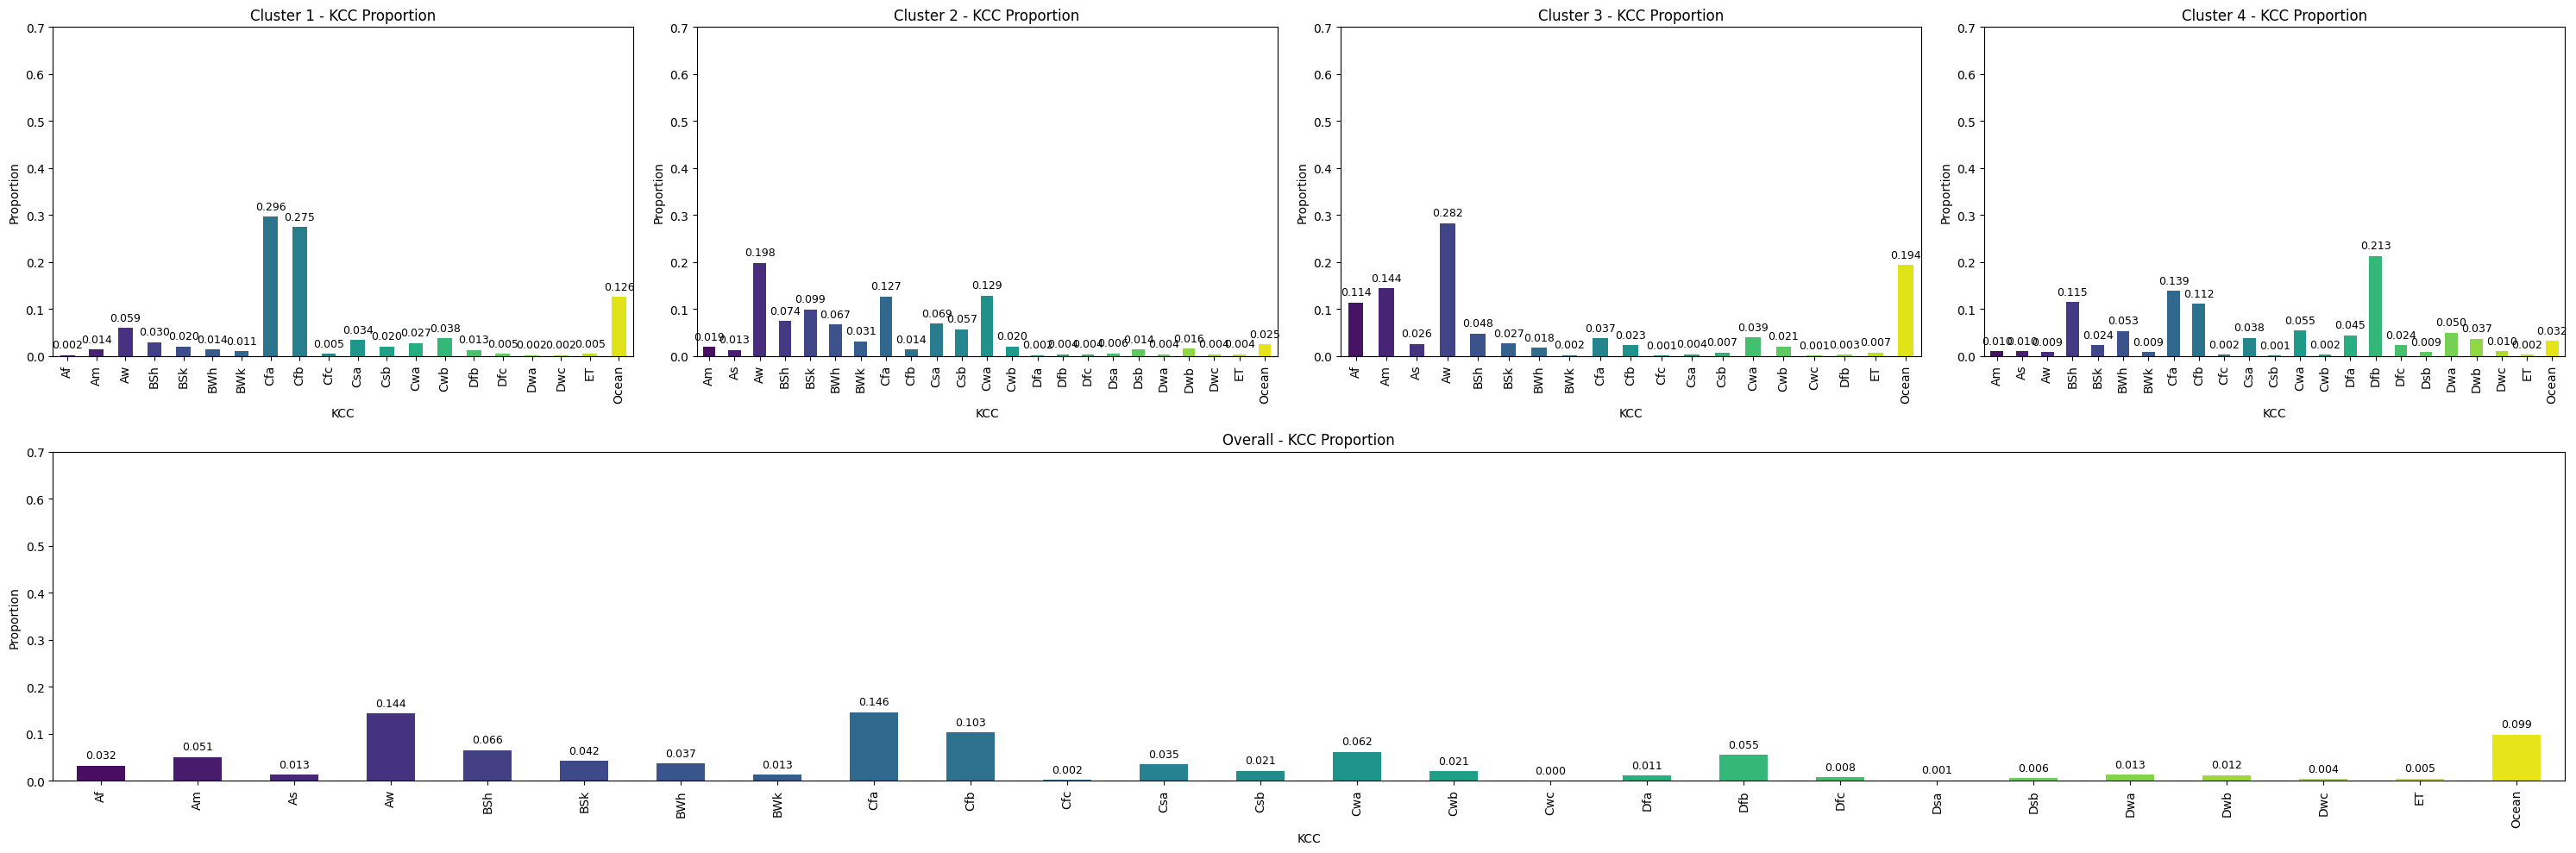

In [31]:
n_clusters = df_kmeans['Cluster'].nunique()
plt.figure(figsize=(30, 10))

for i in range(n_clusters):
    plt.subplot(2, n_clusters, i+1) 
    cluster_data = df_kmeans[df_kmeans['Cluster'] == i]
    kcc_counts = cluster_data['kcc'].value_counts(normalize=True).sort_index()
    bars = kcc_counts.plot(kind='bar', color=sns.color_palette("viridis", len(kcc_counts)))
    plt.title(f'Cluster {i+1} - KCC Proportion')
    plt.ylabel('Proportion')
    plt.xlabel('KCC')
    plt.ylim(0.0, 0.70)
    for index, value in enumerate(kcc_counts):
        plt.text(index, value + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=9, color='black')

plt.subplot(2, 1, 2)
overall_kcc_counts = df_kmeans['kcc'].value_counts(normalize=True).sort_index()
bars = overall_kcc_counts.plot(kind='bar', color=sns.color_palette("viridis", len(overall_kcc_counts)))
plt.title('Overall - KCC Proportion')
plt.ylabel('Proportion')
plt.xlabel('KCC')
plt.ylim(0.0, 0.70)
for index, value in enumerate(overall_kcc_counts):
    plt.text(index, value + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


Visualizing the clusters as a heatmap:

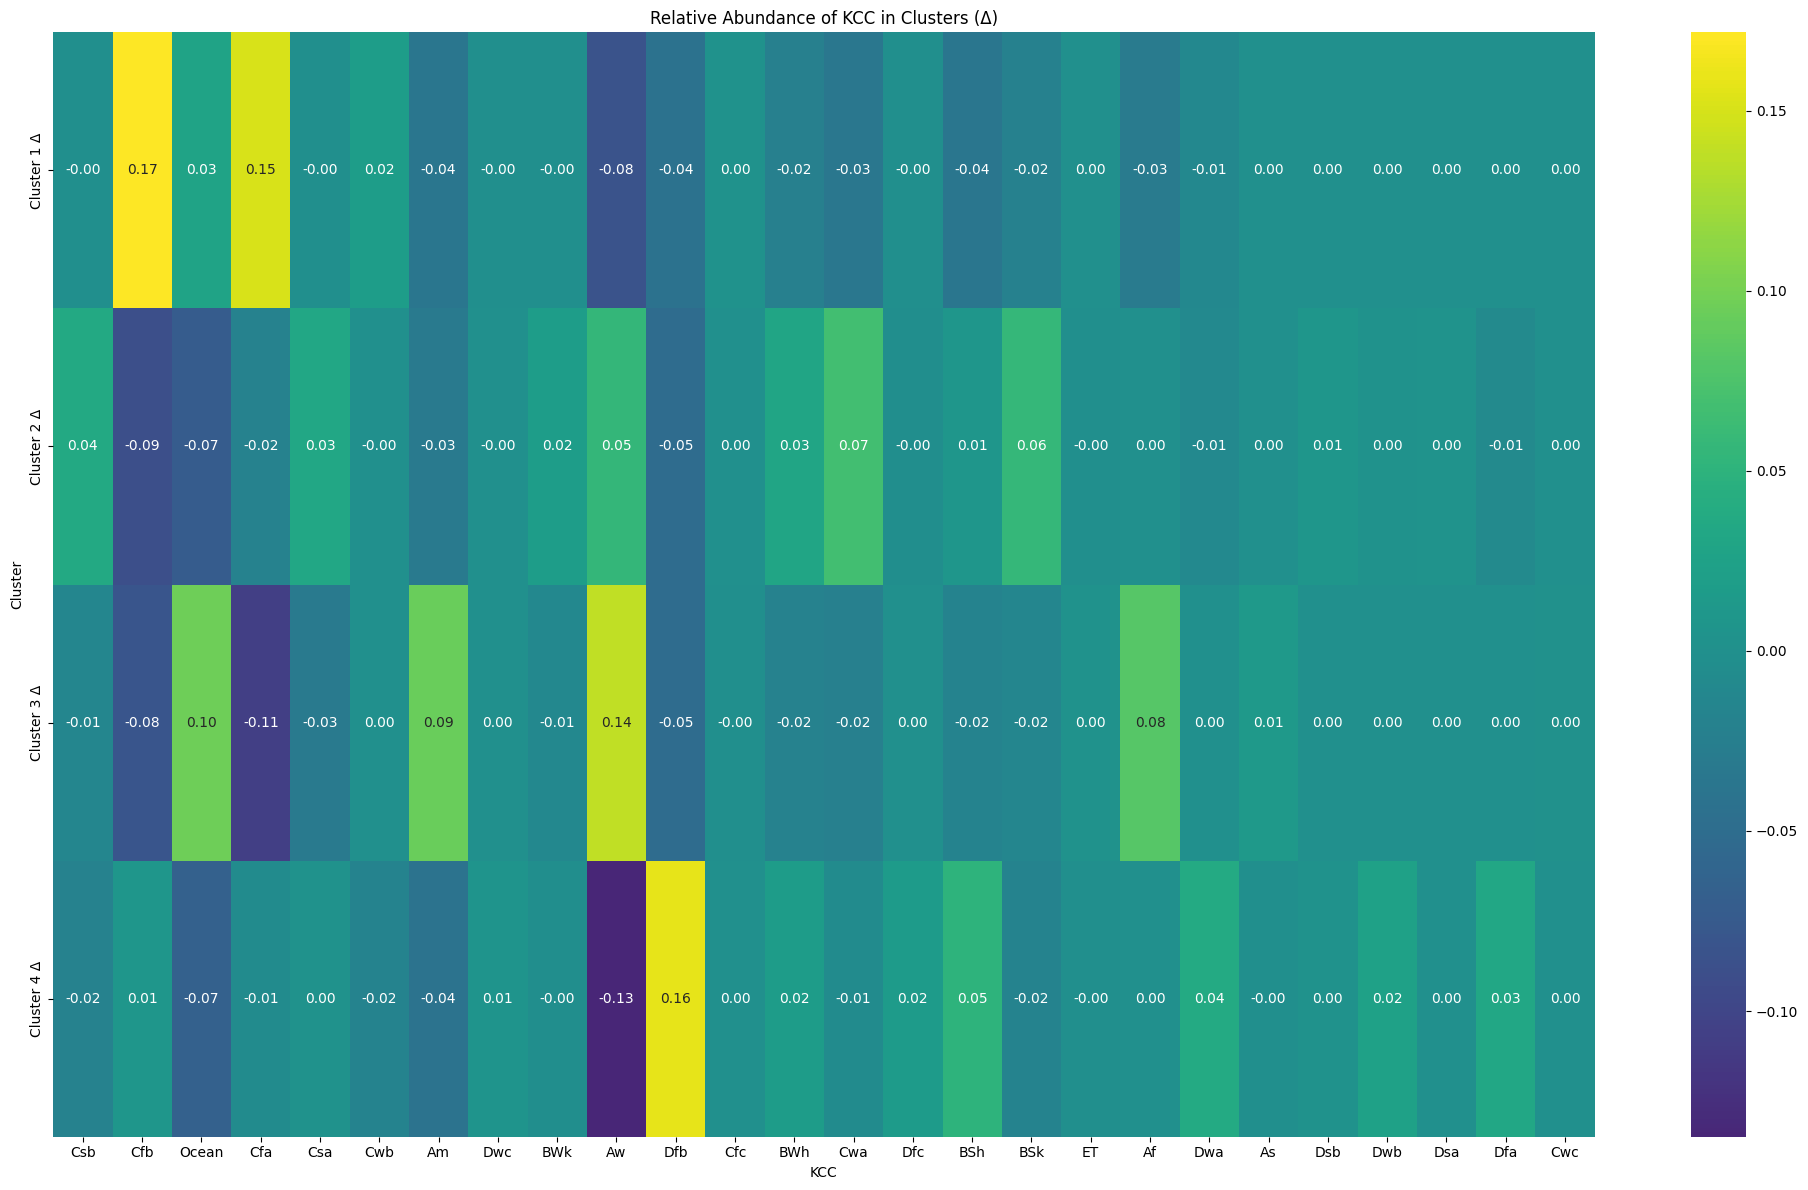

In [32]:
climates = df_kmeans['kcc'].unique()
overall_climate_counts = df_kmeans['kcc'].value_counts(normalize=True)

# Initialize a DataFrame to store the deltas
climate_deltas = pd.DataFrame(index=climates)

# Calculate deltas for each cluster
for i in range(n_clusters):
    cluster_data = df_kmeans[df_kmeans['Cluster'] == i]
    climate_counts = cluster_data['kcc'].value_counts(normalize=True)
    climate_deltas[f'Cluster {i+1} Δ'] = climate_counts - overall_climate_counts

# Transpose the DataFrame for easier plotting with seaborn
climate_deltas = climate_deltas.transpose()

# Replace NaN values with 0 (indicating no difference for missing climates in some clusters)
climate_deltas.fillna(0, inplace=True)

# Sort index for a cleaner look if necessary
climate_deltas.sort_index(inplace=True)

# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(climate_deltas, annot=True, fmt=".2f", cmap="viridis", center=0)
plt.title('Relative Abundance of KCC in Clusters (Δ)')
plt.ylabel('Cluster')
plt.xlabel('KCC')
plt.tight_layout()
plt.show()

Now lets see how geographically spread our clusters are:

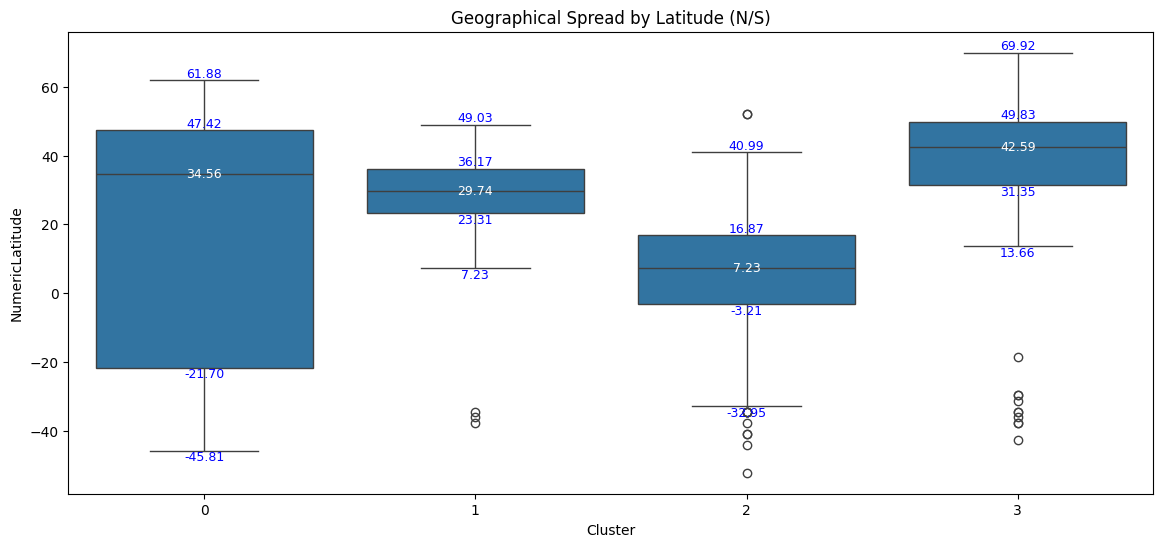

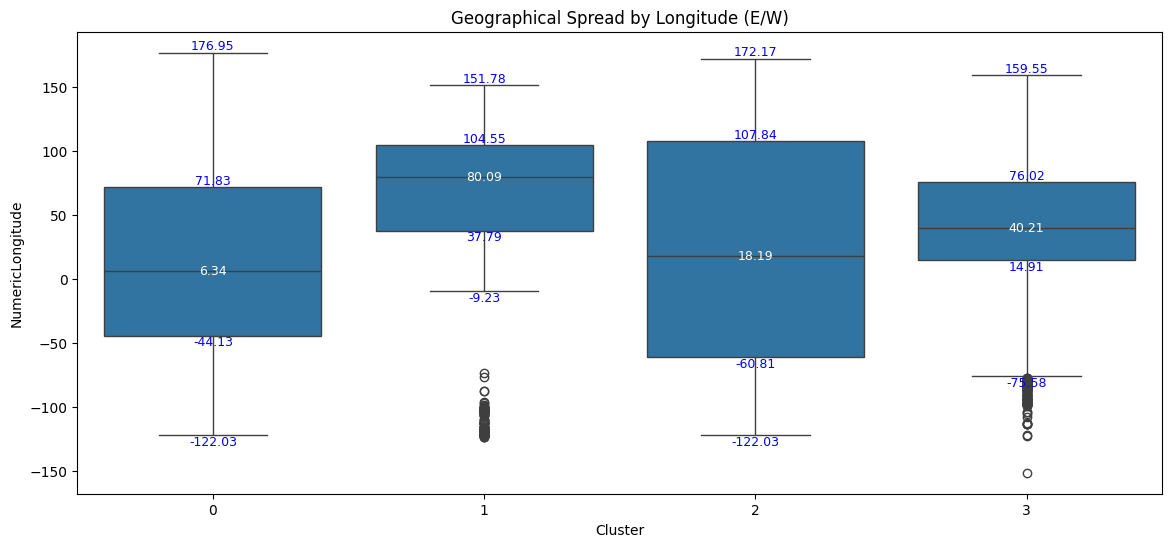

In [33]:
# Latitude
plt.figure(figsize=(14, 6))
sns.boxplot(x='Cluster', y='NumericLatitude', data=df_kmeans)

n_clusters = df_kmeans['Cluster'].nunique()
for i in range(n_clusters):
    cluster_latitudes = df_kmeans[df_kmeans['Cluster'] == i]['NumericLatitude']
    percentiles = np.percentile(cluster_latitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_latitudes[cluster_latitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_latitudes[cluster_latitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Latitude (N/S)')
plt.ylabel('NumericLatitude')
plt.xlabel('Cluster')
plt.show()

# Longitude
plt.figure(figsize=(14, 6))
sns.boxplot(x='Cluster', y='NumericLongitude', data=df_kmeans)
for i in range(n_clusters):
    cluster_Longitudes = df_kmeans[df_kmeans['Cluster'] == i]['NumericLongitude']
    percentiles = np.percentile(cluster_Longitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_Longitudes[cluster_Longitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_Longitudes[cluster_Longitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    # Placing text annotations for percentiles
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Longitude (E/W)')
plt.ylabel('NumericLongitude')
plt.xlabel('Cluster')
plt.show()